# Importation des modules 

In [4]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 5.4 MB/s 
     |████████████████████████████████| 76 kB 6.0 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=fae134cacb47b755af04be0d3adff6801232b24179a53e32102bf027806e95d8
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.0 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 

In [2]:
pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.1 MB/s 


In [5]:
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import warnings
from lifelines import KaplanMeierFitter
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.model_selection import train_test_split, RepeatedKFold
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.exceptions import FitFailedWarning
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

# Import des jeux de données (donner des noms à chaque scénario)

In [6]:
scen1_data1 = pd.read_csv("drive/MyDrive/scen1/data_scen1.csv",index_col=0)
scen1_data1.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X43,X44,X45,X46,X47,X48,X49,X50,y,failed
1,-1.504652,-1.706910,-1.156680,-1.290577,-0.367276,-1.145308,-0.603290,-1.177515,-1.261030,-1.740965,...,-2.042633,-1.585265,-1.156921,-0.739680,-0.799131,-0.190409,-0.525668,0.502982,100,True
2,-1.801625,-2.317740,-1.798168,-1.849040,-1.499665,-1.180965,-0.799036,-1.602407,-0.236973,0.217928,...,-0.129835,0.072848,-0.482063,-0.050411,0.028931,1.213062,1.156208,1.113582,25,False
3,2.224006,2.255983,0.320314,0.748900,0.224691,-0.060714,0.312960,0.460774,0.003259,-0.770549,...,0.394514,-0.785424,-1.088138,-1.785187,-1.729471,-1.029751,-0.008730,0.235676,100,False
4,-1.395282,-1.782209,-1.644641,-1.386603,-1.282772,-0.196608,-0.496779,-0.795624,-0.860817,0.274551,...,-2.860048,-1.009866,-0.628389,-0.301871,0.221696,-0.178775,0.551718,-1.075839,100,False
5,-1.200438,-0.690928,-0.276894,-0.854677,-0.057391,-1.224576,-0.404550,-0.325119,-0.749458,-0.410679,...,1.204621,0.501177,1.193891,0.302516,0.673416,1.035652,1.117256,0.356707,100,False


In [ ]:
### Loop the data lines
"""
with open("drive/MyDrive/scen1/data_scen1.csv", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

### Read csv
scen1_data1 = pd.read_csv("drive/MyDrive/scen1/data_scen1.csv", delimiter=",", names=column_names)
scen1_data1.head()
"""

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,NaN,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X43,X44,X45,X46,X47,X48,X49,X50,y,failed
1,1.0,-1.50465157374885,-1.70690984240112,-1.15667961884669,-1.2905768666253,-0.367275986828764,-1.14530771487381,-0.603289721766942,-1.17751488196981,-1.26102974065241,...,-2.04263339535384,-1.58526521792866,-1.15692055083259,-0.739680480941573,-0.799130738068576,-0.190408870253218,-0.525668431210715,0.502982060370051,100,TRUE
2,2.0,-1.80162456703803,-2.31773974206959,-1.79816752876684,-1.84903973479681,-1.49966489407406,-1.1809649056971,-0.799035762778087,-1.60240664282323,-0.236973049090861,...,-0.129835387873389,0.0728478749733865,-0.482062656242487,-0.05041059506846,0.0289310783396361,1.21306181265304,1.15620799264994,1.11358150727827,25,FALSE
3,3.0,2.22400575312821,2.25598269250885,0.320313849503803,0.748900172343194,0.224691405266872,-0.0607139723983023,0.312960363243994,0.460774465458015,0.00325887779131319,...,0.394514474638278,-0.785424057677769,-1.08813791298528,-1.78518651935123,-1.72947053279514,-1.02975108855489,-0.00873014556838566,0.235676070542554,100,FALSE
4,4.0,-1.39528226071247,-1.78220914119294,-1.64464070123681,-1.3866026435441,-1.28277157770254,-0.1966083129923,-0.496779287882612,-0.795624334997037,-0.860817311013465,...,-2.86004806708348,-1.00986625771595,-0.628388643656288,-0.301870921692584,0.221695978603564,-0.178774600382392,0.551717644573294,-1.07583934333494,100,FALSE


In [ ]:
#scen1_data1 = scen1_data1.drop(0)
#del scen1_data1[0]
#scen1_data1.head()

KeyError: ignored

***Observations du jeu de données***

In [ ]:
scen1_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 52 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      5000 non-null   float64
 1   X2      5000 non-null   float64
 2   X3      5000 non-null   float64
 3   X4      5000 non-null   float64
 4   X5      5000 non-null   float64
 5   X6      5000 non-null   float64
 6   X7      5000 non-null   float64
 7   X8      5000 non-null   float64
 8   X9      5000 non-null   float64
 9   X10     5000 non-null   float64
 10  X11     5000 non-null   float64
 11  X12     5000 non-null   float64
 12  X13     5000 non-null   float64
 13  X14     5000 non-null   float64
 14  X15     5000 non-null   float64
 15  X16     5000 non-null   float64
 16  X17     5000 non-null   float64
 17  X18     5000 non-null   float64
 18  X19     5000 non-null   float64
 19  X20     5000 non-null   float64
 20  X21     5000 non-null   float64
 21  X22     5000 non-null   float64
 22  

In [ ]:
scen1_data1.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X42,X43,X44,X45,X46,X47,X48,X49,X50,y
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.009726,0.016375,0.011573,0.019313,0.017793,0.014906,0.013941,0.006927,0.009053,0.017094,...,-0.006448,-0.009969,-0.017352,-0.013789,-0.010779,-0.000465,-0.003441,-0.010305,-0.019973,47.025200
std,0.990391,0.982979,0.997800,1.002891,1.001502,1.002835,1.000055,1.009312,0.996578,1.001974,...,0.985021,0.975293,0.983857,0.991475,0.999279,1.001437,1.003279,1.007662,0.987049,43.556726
min,-3.481207,-4.154026,-3.772366,-4.004807,-3.943297,-4.148762,-3.652768,-3.415693,-3.923663,-3.485113,...,-3.695032,-3.408134,-3.901223,-3.650558,-3.750057,-3.309073,-4.190666,-4.738502,-3.588608,1.000000
25%,-0.655572,-0.633608,-0.661995,-0.642918,-0.647461,-0.657323,-0.660242,-0.680330,-0.661109,-0.662784,...,-0.675413,-0.674640,-0.673816,-0.675873,-0.690663,-0.679775,-0.676835,-0.677410,-0.665280,1.000000
50%,0.011047,0.039270,0.027228,0.002908,0.019702,0.019944,0.015475,0.010756,0.009262,0.002998,...,-0.010373,0.003579,-0.009524,-0.013688,-0.015864,-0.020509,-0.000261,-0.000281,-0.007806,29.000000
75%,0.689794,0.680598,0.686664,0.691562,0.677057,0.680703,0.687228,0.674292,0.695486,0.701386,...,0.655669,0.664935,0.666638,0.656352,0.666008,0.678784,0.643347,0.655112,0.634490,100.000000
max,3.276240,3.199635,3.729030,3.190350,3.592875,3.661226,3.771416,3.669545,3.778175,3.290979,...,3.476651,3.756461,3.420541,3.357584,3.343794,3.228606,3.674555,3.745614,3.405421,100.000000


In [ ]:
#scen1_data1 = scen1_data1.rename(columns = {52: 'dead'})
#scen1_data1.head()

,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,dead
1,-1.50465157374885,-1.70690984240112,-1.15667961884669,-1.2905768666253,-0.367275986828764,-1.14530771487381,-0.603289721766942,-1.17751488196981,-1.26102974065241,-1.74096488023316,...,-2.04263339535384,-1.58526521792866,-1.15692055083259,-0.739680480941573,-0.799130738068576,-0.190408870253218,-0.525668431210715,0.502982060370051,100,TRUE
2,-1.80162456703803,-2.31773974206959,-1.79816752876684,-1.84903973479681,-1.49966489407406,-1.1809649056971,-0.799035762778087,-1.60240664282323,-0.236973049090861,0.217928011543804,...,-0.129835387873389,0.0728478749733865,-0.482062656242487,-0.05041059506846,0.0289310783396361,1.21306181265304,1.15620799264994,1.11358150727827,25,FALSE
3,2.22400575312821,2.25598269250885,0.320313849503803,0.748900172343194,0.224691405266872,-0.0607139723983023,0.312960363243994,0.460774465458015,0.00325887779131319,-0.77054919038556,...,0.394514474638278,-0.785424057677769,-1.08813791298528,-1.78518651935123,-1.72947053279514,-1.02975108855489,-0.00873014556838566,0.235676070542554,100,FALSE
4,-1.39528226071247,-1.78220914119294,-1.64464070123681,-1.3866026435441,-1.28277157770254,-0.1966083129923,-0.496779287882612,-0.795624334997037,-0.860817311013465,0.274550756416033,...,-2.86004806708348,-1.00986625771595,-0.628388643656288,-0.301870921692584,0.221695978603564,-0.178774600382392,0.551717644573294,-1.07583934333494,100,FALSE
5,-1.20043847816921,-0.690928055837338,-0.276893716515125,-0.854676912967239,-0.0573909630881544,-1.2245760949821,-0.404550371806297,-0.325119401574662,-0.749457557066283,-0.41067887086349,...,1.20462086534909,0.501177062037798,1.19389104190849,0.302516306085515,0.673415562396197,1.03565160785025,1.1172556490804,0.356706842755369,100,FALSE


# Visualisation des données 


## Heatmap des corrélations 

***Headmap des corrélations***

In [7]:
X = scen1_data1.iloc[:,0:50]

In [8]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
1,-1.504652,-1.706910,-1.156680,-1.290577,-0.367276,-1.145308,-0.603290,-1.177515,-1.261030,-1.740965,...,-2.389360,-2.472774,-2.042633,-1.585265,-1.156921,-0.739680,-0.799131,-0.190409,-0.525668,0.502982
2,-1.801625,-2.317740,-1.798168,-1.849040,-1.499665,-1.180965,-0.799036,-1.602407,-0.236973,0.217928,...,0.739494,0.014470,-0.129835,0.072848,-0.482063,-0.050411,0.028931,1.213062,1.156208,1.113582
3,2.224006,2.255983,0.320314,0.748900,0.224691,-0.060714,0.312960,0.460774,0.003259,-0.770549,...,1.111541,0.874643,0.394514,-0.785424,-1.088138,-1.785187,-1.729471,-1.029751,-0.008730,0.235676
4,-1.395282,-1.782209,-1.644641,-1.386603,-1.282772,-0.196608,-0.496779,-0.795624,-0.860817,0.274551,...,-2.992289,-3.048446,-2.860048,-1.009866,-0.628389,-0.301871,0.221696,-0.178775,0.551718,-1.075839
5,-1.200438,-0.690928,-0.276894,-0.854677,-0.057391,-1.224576,-0.404550,-0.325119,-0.749458,-0.410679,...,0.005460,0.769259,1.204621,0.501177,1.193891,0.302516,0.673416,1.035652,1.117256,0.356707


In [9]:
X.corr()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
X1,1.000000,0.800972,0.640134,0.510085,0.418684,0.328571,0.258172,0.214637,0.167749,0.132499,...,0.013531,0.010751,0.013891,0.000383,-0.001378,0.006236,0.007873,0.002959,0.011614,0.003623
X2,0.800972,1.000000,0.792462,0.635046,0.512021,0.406804,0.324892,0.262520,0.209389,0.168706,...,0.023195,0.016156,0.018800,0.003359,-0.002362,0.006955,-0.002028,-0.001986,0.005754,-0.002301
X3,0.640134,0.792462,1.000000,0.804021,0.643248,0.506885,0.405566,0.327214,0.257952,0.204357,...,0.028619,0.018616,0.020977,0.008915,0.001783,0.008932,-0.003065,0.002383,0.009883,0.006791
X4,0.510085,0.635046,0.804021,1.000000,0.794286,0.642448,0.503194,0.406278,0.319905,0.247310,...,0.028557,0.017620,0.012301,0.002365,-0.002751,0.001565,-0.010921,-0.009724,-0.006449,-0.002595
X5,0.418684,0.512021,0.643248,0.794286,1.000000,0.801161,0.635425,0.507404,0.399411,0.306293,...,0.029324,0.009854,0.009654,0.001025,-0.001264,0.000124,-0.011449,-0.013605,-0.009031,-0.013884
X6,0.328571,0.406804,0.506885,0.642448,0.801161,1.000000,0.798555,0.636739,0.501508,0.386527,...,0.014635,0.004899,0.001249,-0.000634,-0.005551,-0.003135,-0.013425,-0.025450,-0.015385,-0.019422
X7,0.258172,0.324892,0.405566,0.503194,0.635425,0.798555,1.000000,0.801241,0.642090,0.502737,...,0.020322,0.007010,-0.003792,-0.000148,0.000661,0.001257,-0.009086,-0.031510,-0.018108,-0.017595
X8,0.214637,0.262520,0.327214,0.406278,0.507404,0.636739,0.801241,1.000000,0.799950,0.625595,...,0.028723,0.015284,0.010461,0.017670,0.010235,-0.002082,-0.006448,-0.020979,-0.008850,-0.019775
X9,0.167749,0.209389,0.257952,0.319905,0.399411,0.501508,0.642090,0.799950,1.000000,0.797475,...,0.027245,0.015896,0.013797,0.010697,-0.003240,-0.017738,-0.023256,-0.030833,-0.020387,-0.022045
X10,0.132499,0.168706,0.204357,0.247310,0.306293,0.386527,0.502737,0.625595,0.797475,1.000000,...,0.013829,0.001855,0.004468,0.009855,0.000221,-0.001808,-0.010803,-0.020839,-0.018595,-0.017177


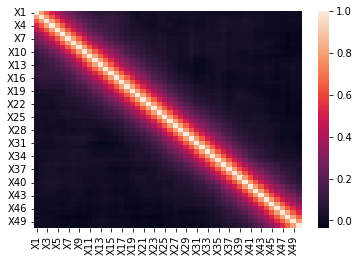

In [10]:
sns.heatmap(X.corr())

## Tableaux (descriptions de chaque variables pour d'une part les censurés, d'autres part les non-censurés et le total)

In [11]:
scen1_data1 = scen1_data1.rename(columns = {'y': 'days'})

In [12]:
y = scen1_data1.iloc[:,50:52]

In [13]:
y["failed"].value_counts()

False    4007
True      993
Name: failed, dtype: int64

On compte 4007 vivants et 993 décès sur un total de 5000 patients. 

In [14]:
4007/5000

0.8014

Le coefficient de corrélation est de 0.8, donc on obtient bien la bonne valeur.

***Kaplan-Meier Estimator***

In [15]:
kmf = KaplanMeierFitter()
kmf.fit(durations = y["days"], event_observed = y["failed"], label="dead")

<lifelines.KaplanMeierFitter:"dead", fitted with 5000 total observations, 4007 right-censored observations>

 *Génération de table d'événement*

In [16]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,5000,5000
1.0,1266,238,1028,0,5000
2.0,235,53,182,0,3734
3.0,159,33,126,0,3499
4.0,100,20,80,0,3340
...,...,...,...,...,...
96.0,3,2,1,0,1785
97.0,5,1,4,0,1782
98.0,4,2,2,0,1777


*Prédiction des probabilités de survie*

In [17]:
kmf.survival_function_

,dead
timeline,
0.0,1.000000
1.0,0.952400
2.0,0.938882
3.0,0.930027
4.0,0.924458
...,...
96.0,0.816891
97.0,0.816432
98.0,0.815513


Text(0.5, 1.0, 'KMF')

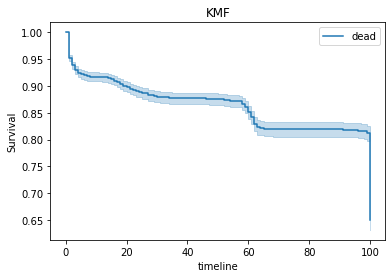

In [18]:
kmf.plot()
plt.ylabel("Survival")
plt.title("KMF")

# Modélisation 


## Modèle de Cox sans sélection de variables et pénalité de Lasso

https://scikit-survival.readthedocs.io/en/stable/user_guide/understanding_predictions.html

Devoir : renommer la variable statine Xstatine + faire l'étude avec scikit-surv et nommer les variables X1, X2, etc... 

Ci-dessous l'estimateur de Kaplan-Meier avec le module scikit-survival.

In [19]:
#y = y.drop(columns=["décès"])
y = y.reindex(columns=["failed", "days"])
y2=y.to_numpy()
#List of tuples
aux = [(e1,e2) for e1,e2 in y2]
#Structured array
new_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
new_y

array([( True, 100.), (False,  25.), (False, 100.), ..., (False,   4.),
       (False,  30.), (False,  59.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [ ]:
for treatment_type in ("X_statin", "X2"):
    mask_treat = treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        new_y["Status"][mask_treat],
        new_y["Survival_in_days"][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

IndexError: ignored

In [20]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X, new_y)

CoxPHSurvivalAnalysis()

In [24]:
estimator.deviance_ratio_

AttributeError: ignored

In [ ]:
pd.Series(estimator.coef_, index=X.columns)

X1     0.037517
X2     0.051365
X3     0.058794
X4     0.096418
X5     0.030759
X6     0.081012
X7     0.011364
X8     0.193910
X9     0.089907
X10    0.016402
X11    0.162334
X12   -0.086193
X13    0.052494
X14    0.204580
X15   -0.020309
X16    0.052034
X17    0.063224
X18    0.097980
X19    0.112338
X20   -0.010783
X21    0.203220
X22    0.011144
X23    0.076223
X24    0.088272
X25    0.052003
X26    0.083410
X27   -0.034863
X28    0.108697
X29    0.013494
X30    0.078174
X31    0.229150
X32   -0.078829
X33    0.127655
X34    0.079611
X35    0.096977
X36    0.045674
X37    0.072821
X38    0.029618
X39    0.104662
X40    0.130904
X41    0.048201
X42    0.044273
X43    0.133450
X44   -0.080165
X45    0.032874
X46    0.086857
X47    0.104971
X48    0.074267
X49    0.112306
X50    0.018814
dtype: float64

KeyboardInterrupt: ignored

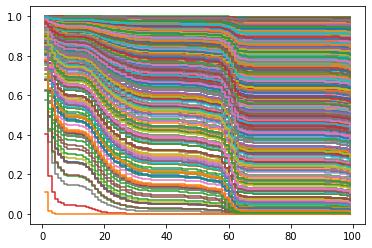

In [ ]:
pd.Series(estimator.coef_, index=X.columns)
pred_surv = estimator.predict_survival_function(X)
time_points = np.arange(1.000000, 100.000000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

**Mesure de la performance du modèle de survie**

La métrique a utilisé est le C-index. Pour cela, nous utilisons la fonction score de l'estimateur. 

In [ ]:
estimator.score(X, new_y)

0.8146607289990115

In [ ]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X.values, new_y)
pd.Series(scores, index=X.columns).sort_values(ascending=False)

X21    0.630188
X8     0.624094
X19    0.622119
X20    0.621878
X9     0.620921
X33    0.618873
X22    0.618697
X35    0.618410
X34    0.618384
X31    0.617810
X24    0.617783
X23    0.617270
X36    0.616410
X25    0.614207
X14    0.613932
X18    0.613831
X39    0.613258
X10    0.612406
X17    0.610418
X11    0.610327
X37    0.610089
X40    0.609263
X15    0.609125
X16    0.608001
X30    0.607068
X13    0.606724
X32    0.606248
X7     0.606201
X38    0.604674
X26    0.604142
X28    0.604121
X12    0.602302
X27    0.600874
X6     0.600286
X29    0.600255
X5     0.595869
X41    0.595325
X4     0.589538
X43    0.584170
X42    0.584048
X3     0.583998
X2     0.574783
X47    0.569933
X48    0.568643
X44    0.566738
X1     0.564462
X46    0.563740
X45    0.563079
X49    0.562151
X50    0.544700
dtype: float64

Ci-dessous la fonction pour étudier les variations des coefficients 🇰

***Modèle de Cox sans sélection de variable + pénalité Lasso***

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

*Lasso*

In [ ]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01) # 0.01 est la valeur par défaut pour un alpha minimum
cox_lasso.fit(X, new_y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

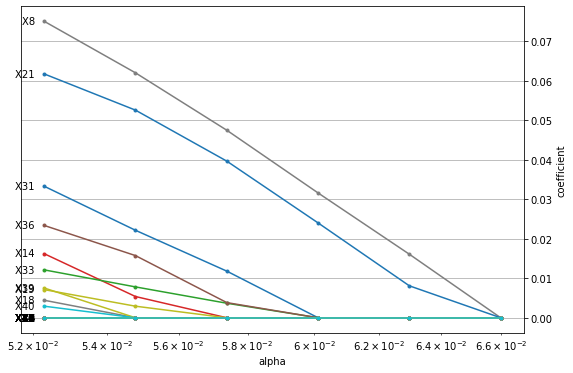

In [ ]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=X.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=50)

La figure ci-dessous nous montre que les coefficients convergent vers 0 pour de grandes valeurs de α. Toutefois, il existe certains coefficients qui sont susceptible de converger vers 0 pour de très faible valeurs de α. 

In [ ]:
# Choix de la valeur alpha pour Lasso
cox_lasso = make_pipeline(
    CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
)
cox_lasso.fit(X, new_y)
# Using the estimated set of alphas, we perform 5 fold cross-validation to estimate the performance – in terms of concordance index – for each α.
estimated_alphas_lasso = cox_lasso.named_steps["coxnetsurvivalanalysis"].alphas_ # d'où ça vient ?
cv_lasso = KFold(n_splits=5, shuffle=True, random_state=0)
gcv_lasso = GridSearchCV(
    cox_lasso,
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas_lasso]},
    cv=cv_lasso,
    error_score=0.5, # score utilisé par défaut
    n_jobs=4).fit(X, new_y)

cv_results_lasso = pd.DataFrame(gcv_lasso.cv_results_)

NameError: ignored

In [ ]:
cox_lasso.named_steps["coxnetsurvivalanalysis"]

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

In [ ]:
estimated_alphas_lasso

array([0.0659832 , 0.06298416, 0.06012143, 0.05738882, 0.05478041,
       0.05229056])

In [ ]:
alphas_lasso = cv_results_lasso.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean_lasso = cv_results_lasso.mean_test_score
std_lasso = cv_results_lasso.std_test_score

Number of non-zero coefficients: 10


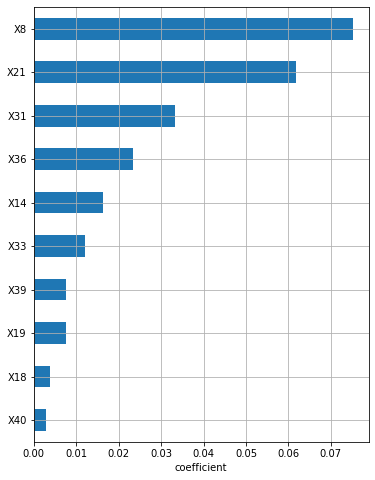

In [ ]:
best_model_lasso = gcv_lasso.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs_lasso = pd.DataFrame(
    best_model_lasso.coef_,
    index=X.columns,
    columns=["coefficient"]
)

non_zero_lasso = np.sum(best_coefs_lasso.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero_lasso))

non_zero_coefs_lasso = best_coefs_lasso.query("coefficient != 0")
coef_order_lasso = non_zero_coefs_lasso.abs().sort_values("coefficient").index

_, ax_lasso = plt.subplots(figsize=(6, 8))
non_zero_coefs_lasso.loc[coef_order_lasso].plot.barh(ax=ax_lasso, legend=False)
ax_lasso.set_xlabel("coefficient")
ax_lasso.grid(True)

In [ ]:
gcv_lasso.best_estimator_.named_steps["coxnetsurvivalanalysis"]

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, alphas=[0.05229055610859352],
                       l1_ratio=1.0)

Le modèle a sélectionné un total de 10 caractéristiques. X8 est la plus élevé ici, X40 est la moins élevée.

***Survival and cumulative hazard function***

In [ ]:
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(X, new_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.057570340924475064],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

In [ ]:
surv_fns = coxnet_pred.predict_survival_function(X)

time_points = np.quantile(new_y["days"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, X.loc[:, "er=positive"].astype(int)):
    line, = ax.step(time_points, fn(time_points), where="post",
                   color="C{:d}".format(label), alpha=0.5)
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("days")
ax.set_ylabel("Survival probability")
ax.grid(True)

ValueError: ignored

## Evaluation de la performance (validation croisée nichée)

### C-index (Concordance index)

Nous utilisons la métrique du C-index pour évaluer la performance de notre modèle. 

In [ ]:
# declare the outer validation cross strategie
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

# create model
model = CoxPHSurvivalAnalysis()

# c'est là, qu'on évalue le modèle 
test_score_normal = cross_val_score(model, X, new_y, cv=outer_cv, n_jobs=2)
print(f"The mean score using nested cross-validation is: "
      f"{test_score_normal.mean():.3f} ± {test_score_normal.std():.3f}")

The mean score using nested cross-validation is: 0.801 ± 0.017


Le score moyen trouvé via l'indice de concordance (métrique utilisée pour mesurer la performance du système) est de 0.801.

In [ ]:
test_score_normal

array([0.81575633, 0.77890572, 0.78289006, 0.81004619, 0.81799245])

*Lasso*

Dans le but de réaliser une validation croisée nichée, nous allons tout d'abord créer une nouvelle colonne avec uniquement des 0 et des 1. 

Tout d'abord, nous utiliserons GridSearch pour trouver les bons paramètres via une validation croisée sur une grille de paramètre minimale. 

Nous utiliserons une validation croisée interne correspondant à la procédure précédente ci-dessus pour optimiser uniquement les hyperparamètres. Nous intégrerons également cette procédure de réglage dans une validation croisée externe, qui est dédiée à l'estimation de l'erreur de test de notre modèle réglé.

Dans ce cas, notre validation croisée interne obtient toujours l'ensemble d'apprentissage de la validation croisée externe, ce qui permet de toujours calculer les scores de test finaux sur des ensembles d'échantillons complètement indépendants.

Faisons cela en une seule fois comme suit :

In [ ]:
# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

cox_lasso = make_pipeline(
    CoxnetSurvivalAnalysis(l1_ratio=1.0)
)

# Inner cross-validation for parameter search
param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas_lasso]}
# optimise les hyperparamètres 
model_lasso = GridSearchCV(
    estimator=cox_lasso, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
# c'est là, qu'on évalue le modèle 
test_score_lasso = cross_val_score(model_lasso, X, new_y, cv=outer_cv, n_jobs=2)
print(f"The mean score using nested cross-validation is: "
      f"{test_score_lasso.mean():.3f} ± {test_score_lasso.std():.3f}")

The mean score using nested cross-validation is: 0.718 ± 0.025


In [ ]:
best_alphas_lasso = list(cv_results_lasso.iloc[5,6:11])

Nous aimerions mieux évaluer la différence entre les scores de validation croisée imbriqués et non imbriqués pour montrer que ces derniers peuvent être trop optimistes en pratique. Pour ce faire, nous répétons l'expérience plusieurs fois et mélangeons les données différemment pour nous assurer que notre conclusion ne dépend pas d'un rééchantillonnage particulier des données.

In [ ]:
best_alphas_lasso

[0.7233196049422208,
 0.7084214249870433,
 0.7052121988057253,
 0.6885624503085602,
 0.7633575653134124]

In [ ]:
test_score_lasso

array([0.7233196 , 0.70842142, 0.7052122 , 0.68856245, 0.76335757])

### Courbe d'apprentissage

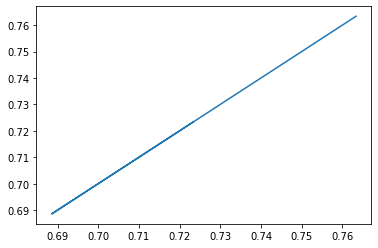

In [ ]:
x = best_alphas_lasso
y = list(test_score_lasso)

plt.plot(x,y)

plt.show() # affiche la figure à l'écran

Devoir : 
- flagguer la variable statine avec X_statine
- comprendre d'où viennent les alphas estimer pour les lasso 
- voir évolution des alpha pour la validation croisée nichée et voir   l'évolution des variables sélectionnés dans le nichée 
- réunion le mardi 01/08 matin à 10h